In [1]:
# utility
import sys
sys.path.append("..")

import utility

# imports
import numpy as np

# modelling
from sklearn.neighbors import LocalOutlierFactor

# Tree Visualization
import matplotlib.pyplot as plt

In [2]:
data, labels, _ = utility.load_data()

Dataset split: 70700 train rows
Dataset split: 70700 test rows


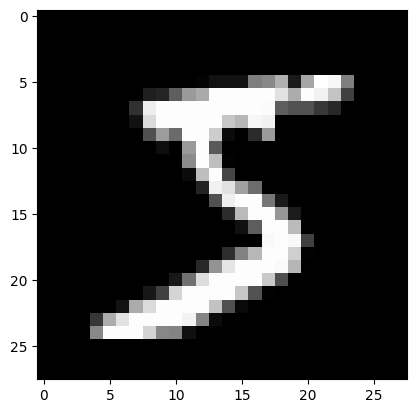

In [3]:
print(f"Dataset split: {len(data)} train rows")
print(f"Dataset split: {len(labels)} test rows")

point = data[0].reshape(28, 28)

plt.imshow(point, cmap='gray')
plt.show()

In [4]:
normal_train_data, anom_train_data, test_data, test_labels = utility.preprocess_data(data, labels, False)

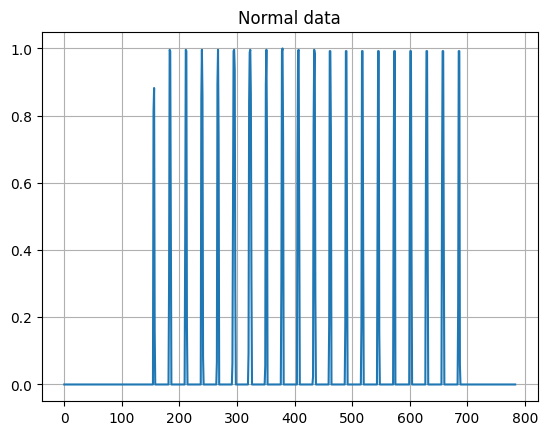

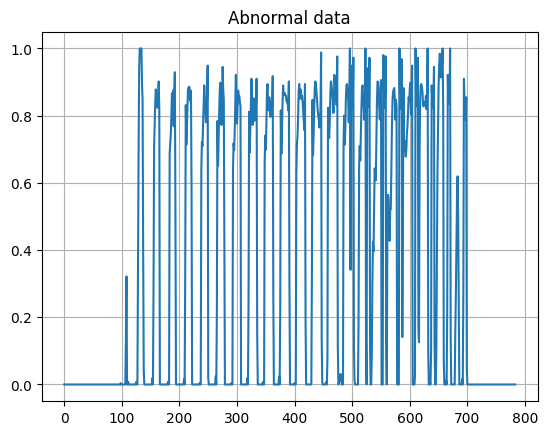

In [5]:
utility.plot_normalized_pixel_data(normal_train_data, anom_train_data)

In [6]:
# Create and fit a Local Outlier Factor model
model = LocalOutlierFactor(n_neighbors=5, contamination=0.05, novelty=True)
model.fit(normal_train_data)

LocalOutlierFactor(contamination=0.05, n_neighbors=5, novelty=True)

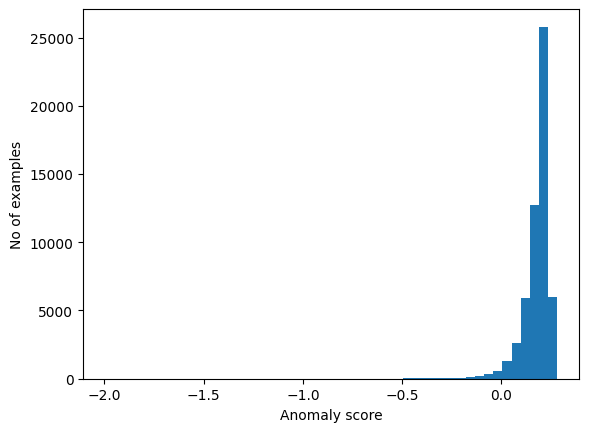

In [7]:
scores = model.decision_function(normal_train_data)

plt.hist(scores[:], bins=50)
plt.xlabel("Anomaly score")
plt.ylabel("No of examples")
plt.show()

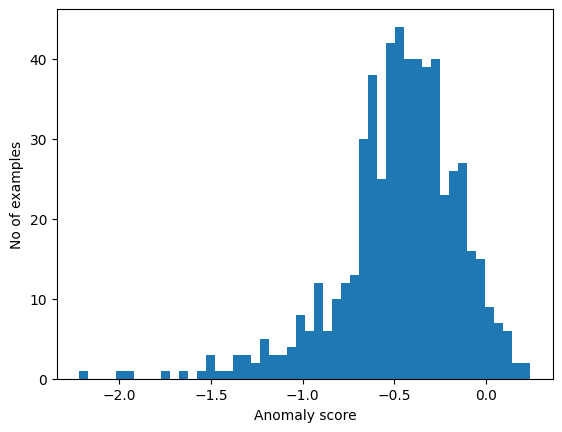

In [8]:
scores = model.decision_function(anom_train_data)

plt.hist(scores[:], bins=50)
plt.xlabel("Anomaly score")
plt.ylabel("No of examples")
plt.show()

In [9]:
# predict
preds = model.predict(test_data)

# Convert to boolean values
preds = [pred == 1 for pred in preds]

# Convert to numpy array
preds = np.array(preds)

In [10]:
# anomaly scores
anomaly_scores = model.decision_function(test_data)

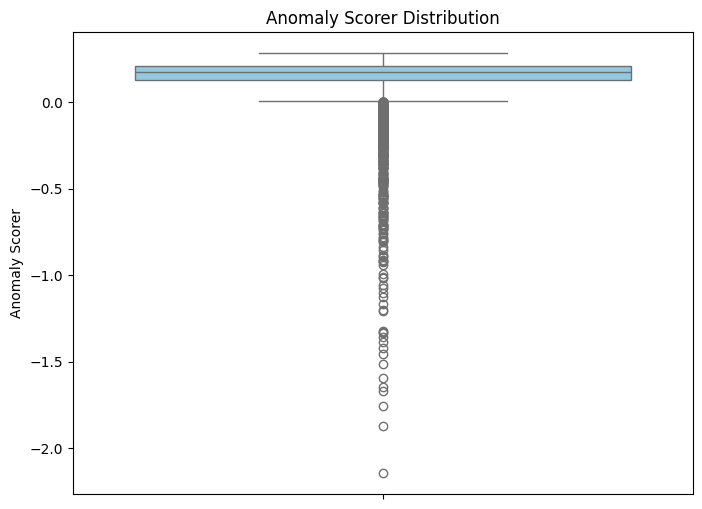

In [11]:
utility.boxplot_plot("Anomaly Scorer", anomaly_scores)

C:\Users\zippe\AppData\Local\Temp\ipykernel_2640\3259029493.py:9: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(range(len(anomaly_scores)), anomaly_scores, c=['blue' if e > threshold else 'red' for e in anomaly_scores], cmap='coolwarm', marker='o', edgecolors='k')


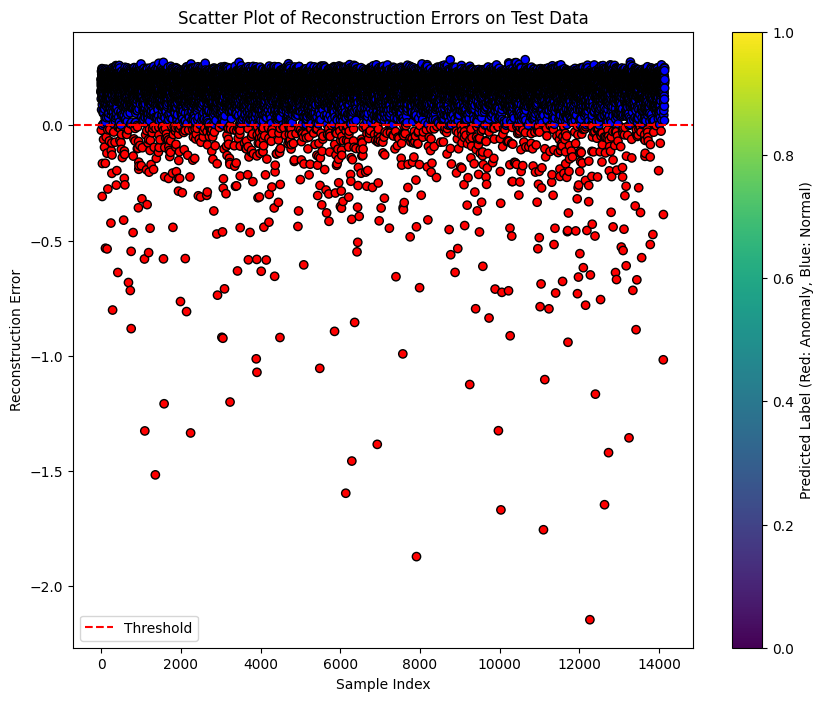

In [12]:
# Set a threshold for classifying anomalies
threshold = 0.0 # Adjust this threshold as needed

# Create a binary array indicating anomalies
anomaly_indicator = np.where(anomaly_scores > threshold, 1, 0)

# Scatter plot with anomalies and normal instances based on anomaly prediction and threshold
plt.figure(figsize=(10, 8))
scatter = plt.scatter(range(len(anomaly_scores)), anomaly_scores, c=['blue' if e > threshold else 'red' for e in anomaly_scores], cmap='coolwarm', marker='o', edgecolors='k')
plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold')
plt.title('Scatter Plot of Reconstruction Errors on Test Data')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.colorbar(scatter, label='Predicted Label (Red: Anomaly, Blue: Normal)')
plt.show()

In [13]:
a, p, r, report, cm = utility.get_metrics(preds, test_labels)

In [14]:
utility.print_stats(a, p, r, report, cm)

Accuracy = 0.9484441301272984
Precision = 0.9993984510113543
Recall = 0.9485441050528118
Report
               precision    recall  f1-score   support

     anomaly       0.14      0.94      0.25       128
      normal       1.00      0.95      0.97     14012

    accuracy                           0.95     14140
   macro avg       0.57      0.94      0.61     14140
weighted avg       0.99      0.95      0.97     14140

Confusion Matrix
[[  120     8]
 [  721 13291]]


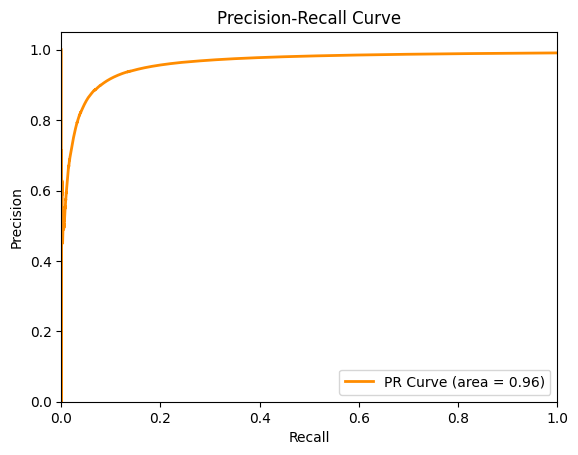

In [15]:
utility.pr_auc_plot(anomaly_scores, test_labels, True)

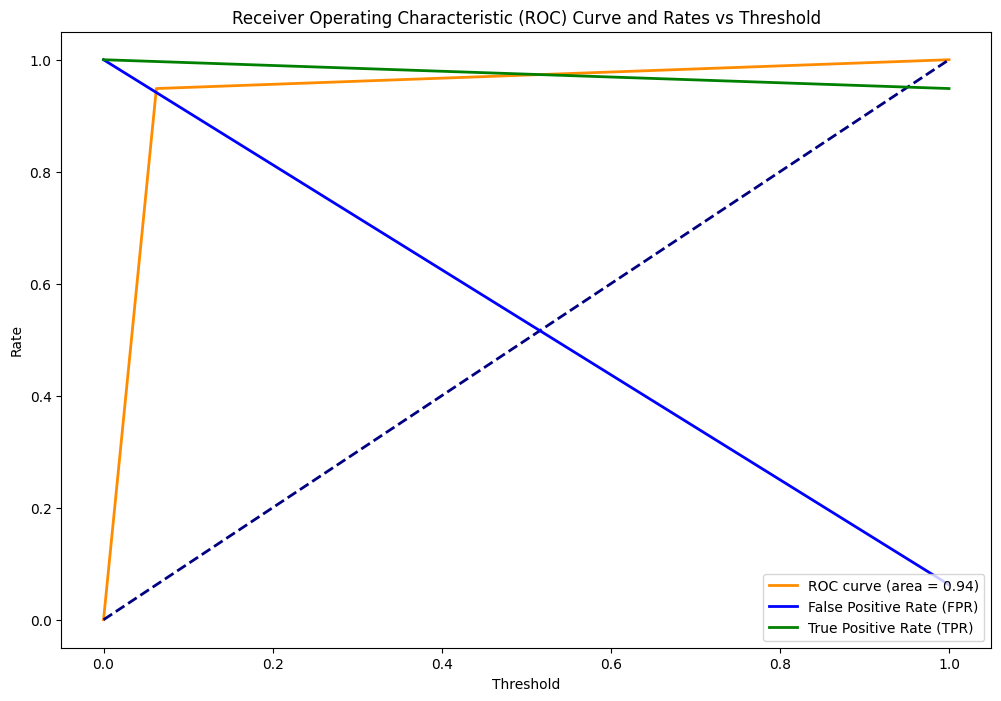

In [16]:
utility.roc_plot(preds, test_labels)

True Negatives: 120
False Positives: 8
False Negatives: 721
True Positives: 13291


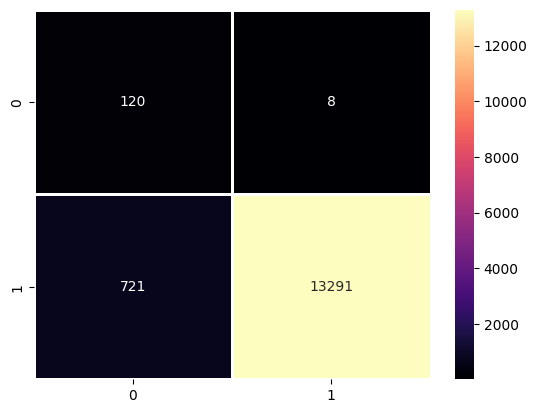

In [20]:
utility.create_heatmap(cm)

In [18]:
anomaly_indexes = utility.write_to_json(preds)

Anomaly indexes saved to .\anomalies.json


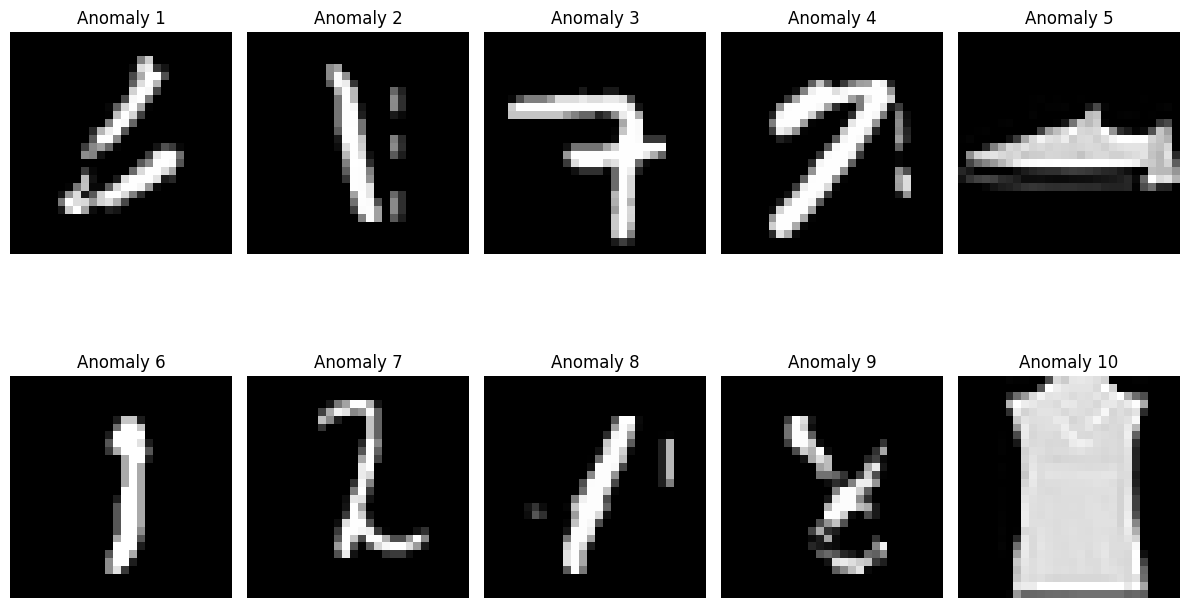

In [19]:
utility.plot_anomaly_imgs(anomaly_indexes, test_data)